Build and train a graph convolutional neural network using PyTorch Geometric for the node property prediction task.

We will use ogbn-products dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## OGBN-Products

The ogbn-products dataset is an undirected and unweighted graph, representing an Amazon product co-purchasing network. Nodes represent products sold in Amazon, and edges between two products indicate that the products are purchased together. Node features are generated by extracting bag-of-words features from the product descriptions followed by a Principal Component Analysis to reduce the dimension to 100.

The task is to predict the category of a product in a multi-class classification setup, where the 47 top-level categories are used for target labels.

In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.0.1+cu118


Download the necessary packages for PyG. Make sure that your version of torch matches the output from the cell above. In case of any issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [ ]:
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
!pip install torch-geometric
!pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 64.3 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=72bbe5810edf00567c824b452a0b2adc932c19a482d6eec28e13dfeeb8f332e0
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=

In [ ]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
import numpy as np
from torch_geometric.typing import SparseTensor
import pandas as pd

## Load and Preprocess the Dataset

This dataset is very big and if you try to run it as it is on colab, you may get an out of memory error.

One solution is to use batching and train on subgraphs. Here, we will just make a smaller dataset so that we can train it in one go.

In [ ]:
dataset_name = 'ogbn-products'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor(), root='/content/drive/MyDrive/GCN')
data = dataset[0]

# We need to have edge indxes to make a subgraph. We can get those from the adjacency matrix.
data.edge_index = torch.stack([data.adj_t.__dict__["storage"]._row, data.adj_t.__dict__["storage"]._col])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

# We will only use the first 100000 nodes.
sub_nodes = 100000
sub_graph = data.subgraph(torch.arange(sub_nodes))
data = None
# Update the adjaceny matrix according to the new graph
sub_graph.adj_t = SparseTensor(
    row=sub_graph.edge_index[0],
    col=sub_graph.edge_index[1],
    sparse_sizes=None,
    is_sorted=True,
    trust_data=True,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

sub_graph = sub_graph.to(device)

sub_graph


# data = data.to(device)
# split_idx = dataset.get_idx_split()
# train_idx = split_idx['train'].to(device)

Device: cpu
Device: cpu


Data(num_nodes=100000, x=[100000, 100], y=[100000, 1], adj_t=[100000, 100000, nnz=2818046], edge_index=[2, 2818046])

In [ ]:
# Spilt data into train validation and test set
split_sizes = [int(sub_nodes*0.8),int(sub_nodes*0.05),int(sub_nodes*0.15)]
indices = torch.arange(sub_nodes)
np.random.shuffle(indices.numpy())
split_idx = {s:t for t,s in zip(torch.split(indices, split_sizes, dim=0), ["train", "valid", "test"])}
train_idx = split_idx['train'].to(device)
split_idx

{'train': tensor([  544, 71612,  8250,  ..., 92071,  8414, 98230]),
 'valid': tensor([44967, 74609, 21820,  ..., 80459, 20834, 11961]),
 'test': tensor([97849, 52850, 74205,  ..., 10283, 94934,  2638])}

In [ ]:
print(f"Feature Length of each node: {sub_graph.x.shape[1]}")

Feature Length of each node: 100


## GCN Model

Now we will implement our GCN model!

The `forward` function is implemented following the figure below.


![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = [
            GCNConv(input_dim, hidden_dim),
        ]

        for _ in range(num_layers-1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.last_layer = GCNConv(hidden_dim, output_dim)


        # A list of 1D batch normalization layers
        self.bns = []
        for _ in range(num_layers):
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        self.convs = torch.nn.ModuleList(self.convs)
        self.bns = torch.nn.ModuleList(self.bns)

        # The log softmax layer
        self.softmax = torch.nn.LogSoftmax()


        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):

        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.last_layer(x, adj_t)

        if not self.return_embeds:
          x = self.softmax(x)

        return x


# Training

In [ ]:
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()
    loss = 0

    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.adj_t)  # Perform a single forward pass.
    loss = loss_fn(out[train_idx], data.y[train_idx].reshape(-1))

    loss.backward()
    optimizer.step()

    return loss.item()

# Testing

In [ ]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results=False):
    model.eval()


    # The output of model on all data
    out = model(data.x, data.adj_t)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
      print ("Saving Model Predictions")

      true_val = data.y
      data = {}
      data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()


      pred_val = y_pred.view(-1).cpu().detach()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      df.to_csv('ogbn-product_node.csv', sep=',', index=False)


    return train_acc, valid_acc, test_acc, pred_val, true_val

# Hyperparameters

In [ ]:
args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 50,
}
args

{'device': 'cpu',
 'num_layers': 3,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.01,
 'epochs': 50}

In [ ]:
model = GCN(sub_graph.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-products')

# Running

In [ ]:
import copy
loss_list = []
train_list = []
val_list = []
test_list = []
# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  loss = train(model, sub_graph, split_idx['train'], optimizer, loss_fn)
  result = test(model, sub_graph, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')
  loss_list.append(loss)
  train_list.append(train_acc * 100)
  val_list.append(valid_acc * 100)
  test_list.append(test_acc * 100)

<ipython-input-9-bd2bcc944472>:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Epoch: 01, Loss: 4.2044, Train: 64.03%, Valid: 63.70% Test: 63.64%
Epoch: 02, Loss: 1.7909, Train: 73.80%, Valid: 73.96% Test: 73.53%
Epoch: 03, Loss: 1.1294, Train: 78.97%, Valid: 78.94% Test: 78.99%
Epoch: 04, Loss: 0.9224, Train: 81.53%, Valid: 81.32% Test: 81.73%
Epoch: 05, Loss: 0.8246, Train: 82.28%, Valid: 82.02% Test: 82.47%
Epoch: 06, Loss: 0.7649, Train: 83.04%, Valid: 82.48% Test: 83.29%
Epoch: 07, Loss: 0.7173, Train: 83.71%, Valid: 83.38% Test: 83.83%
Epoch: 08, Loss: 0.6716, Train: 84.25%, Valid: 84.28% Test: 84.36%
Epoch: 09, Loss: 0.6414, Train: 84.85%, Valid: 85.02% Test: 85.14%
Epoch: 10, Loss: 0.6137, Train: 85.36%, Valid: 85.52% Test: 85.62%
Epoch: 11, Loss: 0.5963, Train: 85.81%, Valid: 85.74% Test: 85.97%
Epoch: 12, Loss: 0.5830, Train: 86.00%, Valid: 86.06% Test: 86.18%
Epoch: 13, Loss: 0.5725, Train: 86.11%, Valid: 86.10% Test: 86.35%
Epoch: 14, Loss: 0.5632, Train: 86.37%, Valid: 86.30% Test: 86.59%
Epoch: 15, Loss: 0.5566, Train: 86.73%, Valid: 86.76% Test: 86

# Visualizing the results
- Loss figure
- Accurancy figure
- Confusion Matrix figure

  - Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa : both variants are found in the literature. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another).

  - It is a special kind of contingency table, with two dimensions ("true" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table).

- Actually, there are only 39 classes in the first 100,000 nodes. So, I just set the labels by the original order till the 39th label.

Text(0, 0.5, 'Loss')

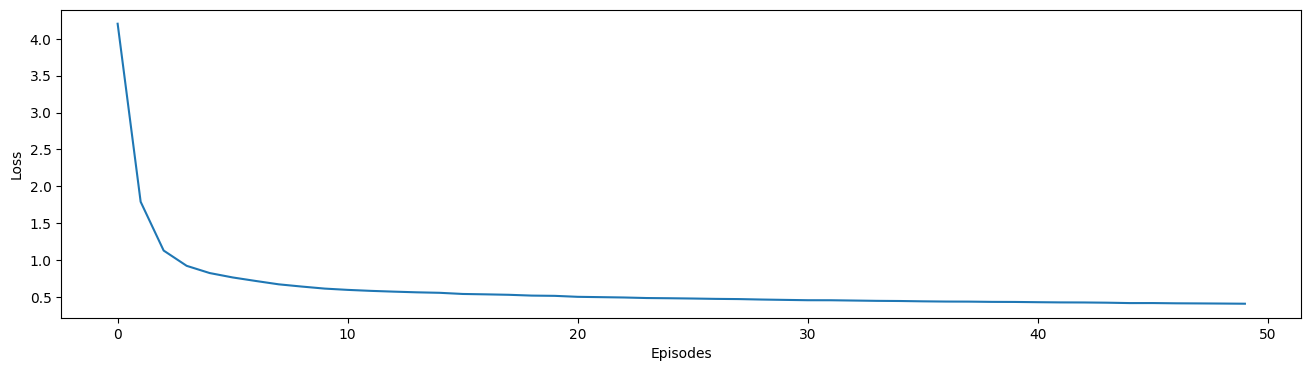

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(loss_list)
plt.xlabel("Episodes")
plt.ylabel("Loss")

Text(0, 0.5, 'Accurancy')

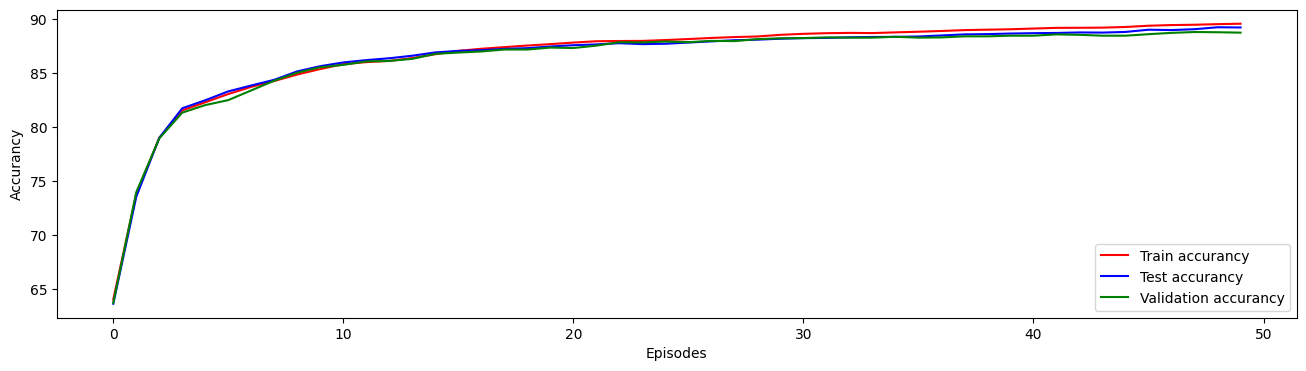

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(train_list, color='r', linewidth=1.5, linestyle='-', label='Train accurancy')
plt.plot(test_list, color='b', linewidth=1.5, linestyle='-', label='Test accurancy')
plt.plot(val_list, color='g', linewidth=1.5, linestyle='-', label='Validation accurancy')
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Accurancy")

In [ ]:
best_result = test(best_model, sub_graph, split_idx, evaluator, save_model_results=True)
train_acc, valid_acc, test_acc, pred, true = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

print(pred)
print(true)

<ipython-input-9-bd2bcc944472>:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Saving Model Predictions
Best model: Train: 89.45%, Valid: 88.78% Test: 89.04%
tensor([ 0,  1,  2,  ...,  7,  4, 11])
tensor([[ 0],
        [ 1],
        [ 2],
        ...,
        [ 7],
        [ 4],
        [11]])


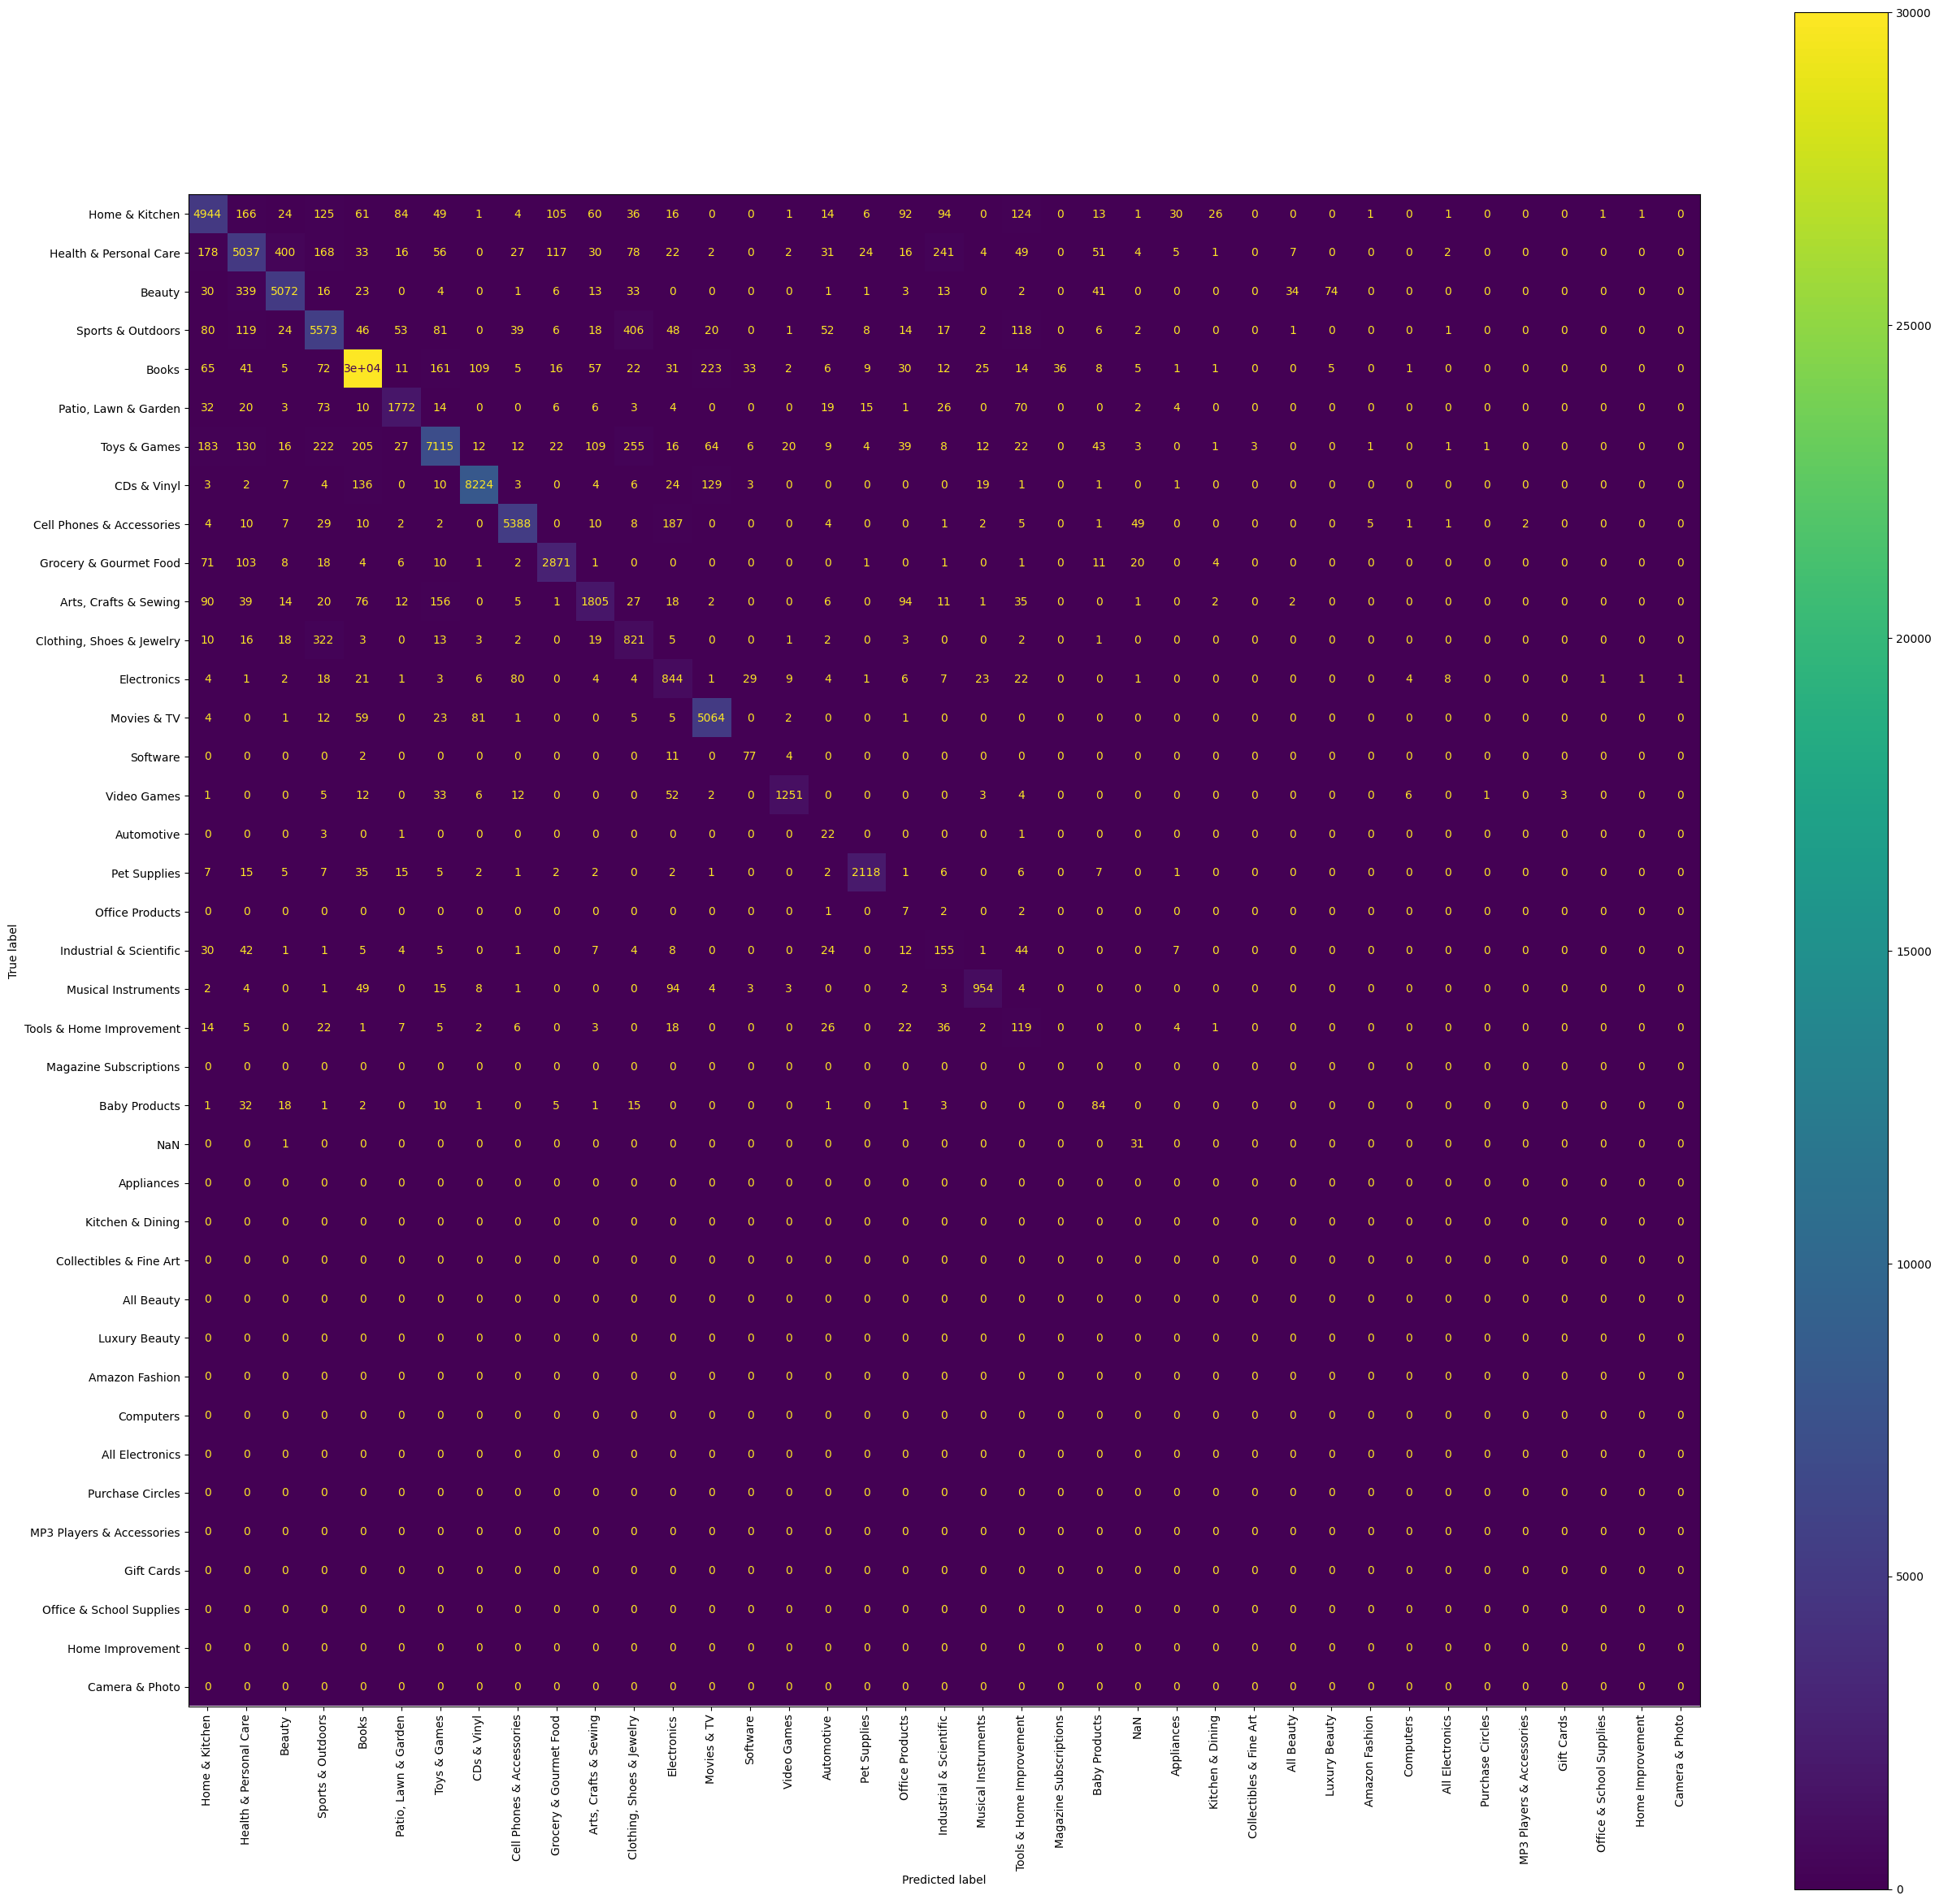

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred.cpu(), true.cpu())
disp = ConfusionMatrixDisplay(cm, display_labels = ['Home & Kitchen', 'Health & Personal Care','Beauty','Sports & Outdoors','Books', 'Patio, Lawn & Garden','Toys & Games','CDs & Vinyl','Cell Phones & Accessories','Grocery & Gourmet Food','Arts, Crafts & Sewing','Clothing, Shoes & Jewelry','Electronics','Movies & TV','Software','Video Games','Automotive','Pet Supplies','Office Products','Industrial & Scientific','Musical Instruments', 'Tools & Home Improvement','Magazine Subscriptions','Baby Products','NaN', 'Appliances', 'Kitchen & Dining','Collectibles & Fine Art','All Beauty','Luxury Beauty','Amazon Fashion','Computers','All Electronics','Purchase Circles','MP3 Players & Accessories','Gift Cards','Office & School Supplies', 'Home Improvement','Camera & Photo'])

fig, ax = plt.subplots(figsize=(30,30))
# ax.set_xticklabels(rotation=90)
disp.plot(ax=ax,xticks_rotation="vertical")